In [47]:
import numpy as np
import matplotlib.pyplot as plt

### Funciones

In [48]:
def permutation():
    global order, N
    order = np.random.permutation(N)

def vecino(s, j):
    global L, empty
    if j == 0:  # izquierda
        if s % L == 0:
            return empty
        else:
            return s - 1
    elif j == 1:  # derecha
        if s % L == L - 1:
            return empty
        else:
            return s + 1
    elif j == 2:  # abajo
        if s // L == 0:
            return empty
        else:
            return s - L
    elif j == 3:  # arriba
        if s // L == L - 1:
            return empty
        else:
            return s + L

def boundaries():
    global N, nn
    for s in range(N):
        for j in range(4):
            nn[s, j] = vecino(s, j)

def findroot(r):
    global parent
    while parent[r] >= 0:
        r = parent[r]
    return r

In [49]:
def mergeroots(r1, r2):
    global spanclussize, parent, ns, touchesLeft, touchesRight, Ss, sum_s2_ns
    if r1 == r2:
        return r1
    elif -parent[r1] > -parent[r2]:
        ns[-parent[r1]] -= 1
        ns[-parent[r2]] -= 1
        sum_s2_ns -= parent[r1]**2
        sum_s2_ns -= parent[r2]**2
        parent[r1] += parent[r2]
        parent[r2] = r1
        ns[-parent[r1]] += 1
        sum_s2_ns += parent[r1]**2
        touchesLeft[r1] = touchesLeft[r1] or touchesLeft[r2]
        touchesRight[r1] = touchesRight[r1] or touchesRight[r2]
        if touchesLeft[r1] and touchesRight[r1]:
            spanclussize = -parent[r1]
        return r1
    else:
        ns[-parent[r1]] -= 1
        ns[-parent[r2]] -= 1
        sum_s2_ns -= parent[r1]**2 
        sum_s2_ns -= parent[r2]**2
        parent[r2] += parent[r1]
        parent[r1] = r2
        ns[-parent[r2]] += 1
        sum_s2_ns += parent[r2]**2
        touchesLeft[r2] = touchesLeft[r2] or touchesLeft[r1]
        touchesRight[r2] = touchesRight[r2] or touchesRight[r1]
        if touchesLeft[r2] and touchesRight[r2]:
            spanclussize = -parent[r2]
        return r2

In [50]:
def percolate():
    global spanclussize, order, parent, nn, ipc, ns, S, Ss, sum_s2_ns

    PSpan = []
    spanclussize = 0
    ns = np.zeros(N + 1, dtype=int)
    nspcpar = np.zeros(N + 1, dtype=int)  # Inicializar nspcpar aquí

    parent = empty * np.ones(N, dtype=int)

    S = []
    sum_s2_ns = 0  # Inicializar la suma acumulativa de s**2 * ns
    den = 0 

    for i in range(N):
        r1 = s1 = order[i]
        parent[s1] = -1
        ns[1] += 1
        sum_s2_ns += 1
        for j in range(4):
            s2 = nn[s1, j]
            if s2 != empty and parent[s2] != empty:
                r1 = mergeroots(r1, findroot(s2))
        
        PSpan.append(spanclussize / (i + 1))

        den = (i+1 - spanclussize)
        if den == 0:
            Ss = 0
        else:
            Ss = (sum_s2_ns - (spanclussize**2)) / den
        
        S.append(Ss)

        if i + 1 > spanclussize:
            S[i] = (sum_s2_ns - spanclussize**2) / (i + 1 - spanclussize)

        if i == ipc:
            nspcpar = np.copy(ns)

    return np.array(PSpan), nspcpar, S

In [74]:
def lineFit(x, y):
    ''' Returns slope and y-intercept of linear fit to (x,y)
    data set'''
    xavg = x.mean()
    slope = (y * (x - xavg)).sum() / (x * (x - xavg)).sum()
    yint = y.mean() - slope * xavg
    return slope, yint

## Problema 3

In [61]:
# Configuración inicial
global L, N, empty, parent, nn, order, spanclussize, touchesLeft, touchesRight, S

sizes = [16, 32, 64, 128, 256]
muestras = 100

sprom_dict = {}
Pspanprom_dict = {}
nspc_dic = {}
Smax = {}
P_infty = {}
pc = 0.59275

for L in sizes:
    N = L**2
    empty = -(N + 1)
    nn = np.zeros((N, 4), dtype=int)
    boundaries()

    ipc = int(N * pc) - 1
    s = np.arange(0, N + 1, 1, dtype=int)
    nspcprom = np.zeros(N)
    Sprom = np.zeros(N)
    sprom = np.zeros(N)
    Pspanprom = np.zeros(N)

    for _ in range(muestras):
        touchesLeft = [i % L == 0 for i in range(N)]
        touchesRight = [i % L == L - 1 for i in range(N)]
        parent = empty * np.ones(N, dtype=int)
        permutation()
        PSpan, nspc, S = percolate()
        nspc = nspc[1:]
        Pspanprom += PSpan
        nspcprom += nspc
        sprom += S

    if spanclussize == muestras:
        sprom_dict[L] = np.nan
    else:
        sprom_dict[L] = sprom / muestras

    Pspanprom /= muestras
    nspcprom /= muestras

    Pspanprom_dict[L] = Pspanprom
    P_infty[L] = Pspanprom[ipc]
    nspc_dic[L] = nspcprom
    Smax[L] = sprom.max()

### Gráficas

In [62]:
# Configuración de estilo de las gráficas
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Tahoma']
plt.rc('mathtext', fontset='stix')

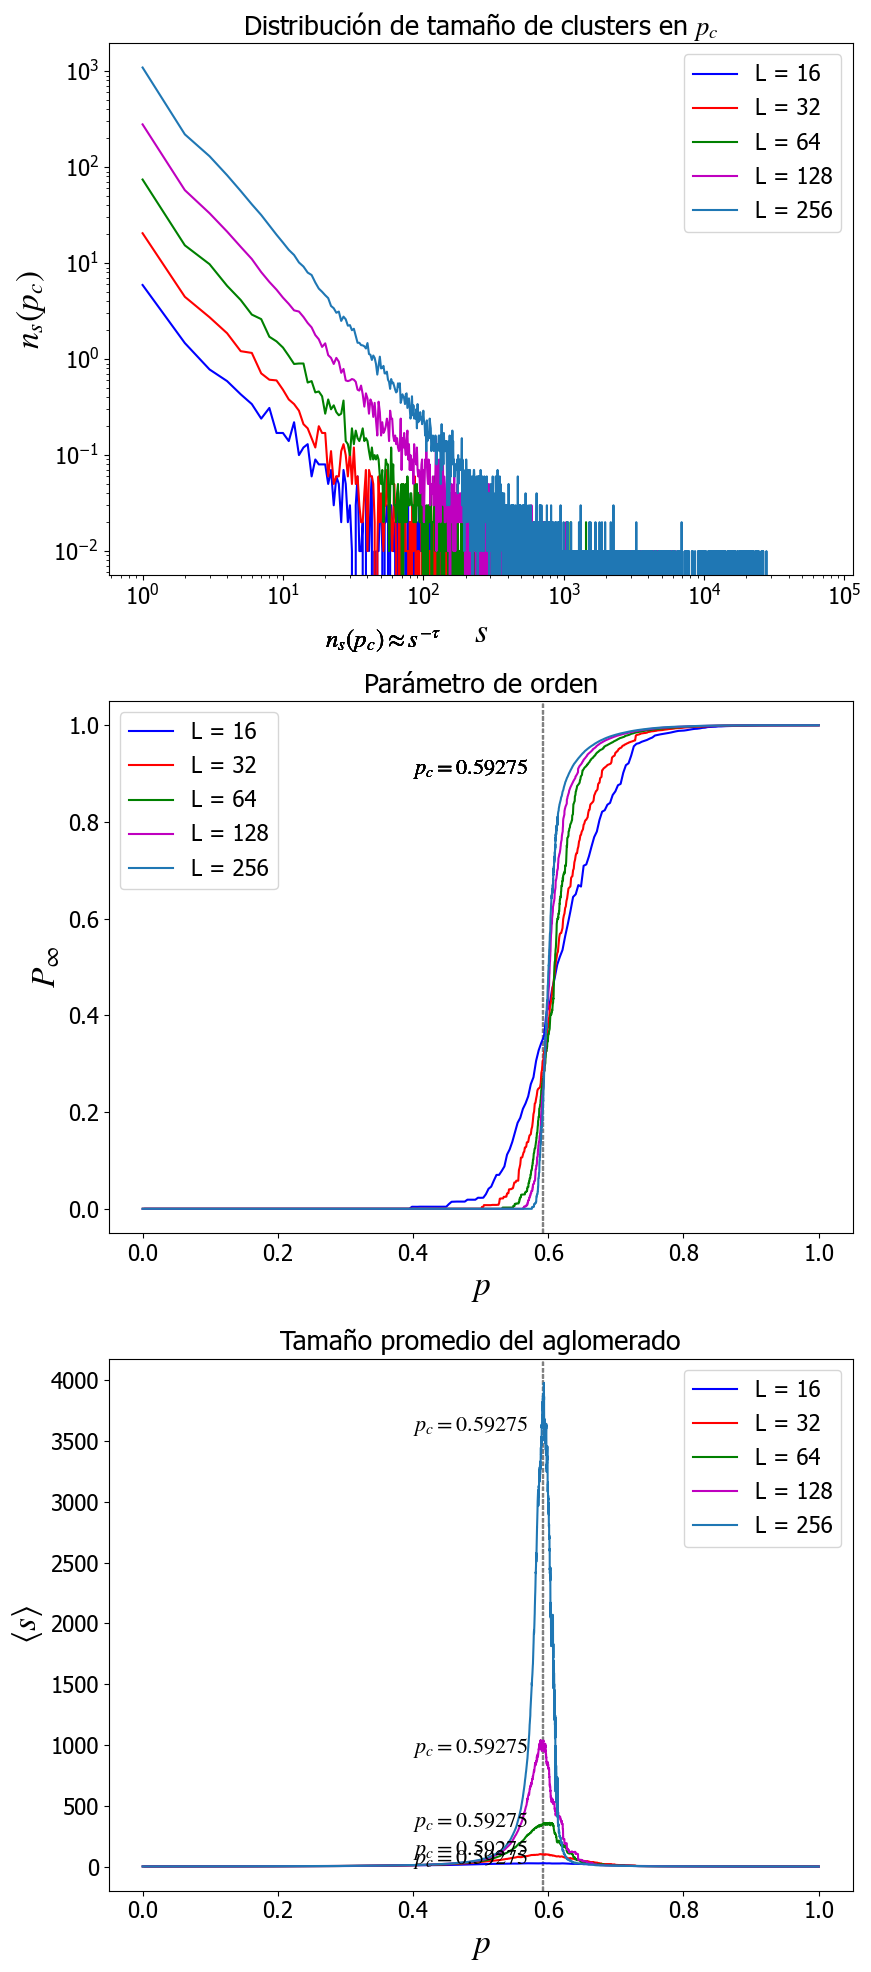

In [63]:
# Gráficas

colors = ['b', 'r', 'g', 'm', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
fig, axs = plt.subplots(3, 1, figsize=(9, 20))  # Cambia a 4 subplots

for i, L in enumerate(sizes):
    N = L**2
    p = np.arange(1, N + 1) / N
    s = np.arange(1, N + 1)

    # Distribución de tamaño de clusters en p_c
    axs[0].loglog(s, nspc_dic[L], color=colors[i], label=f"L = {L}")
    axs[0].set_xlabel(r"$s$", fontsize=24)
    axs[0].set_ylabel(r"$n_s(p_c)$", fontsize=24)
    axs[0].set_title("Distribución de tamaño de clusters en $p_c$")
    axs[0].text(20, 0.001, r'$n_s(p_c) \approx s^{-\tau}$', fontsize=18)
    
    # Parámetro de orden
    axs[1].plot(p, Pspanprom_dict[L], color=colors[i], label=f"L = {L}")
    axs[1].set_xlabel(r"$p$", fontsize=24)
    axs[1].set_ylabel(r"$P_\infty$", fontsize=24)
    axs[1].set_title("Parámetro de orden")
    axs[1].axvline(pc, color="gray", dashes=(2, 1), zorder=-1)
    axs[1].text(0.4, 0.9, r'$p_c = 0.59275$')
    
    # Tamaño promedio del aglomerado
    axs[2].plot(p, sprom_dict[L], color=colors[i], label=f"L = {L}")
    axs[2].set_xlabel(r"$p$", fontsize=24)
    axs[2].set_ylabel(r"$\langle s \rangle$", fontsize=24)
    axs[2].set_title("Tamaño promedio del aglomerado")
    axs[2].axvline(pc, color="gray", dashes=(2, 1), zorder=-1)
    axs[2].text(0.4, 0.9 * max(sprom_dict[L]), r'$p_c = 0.59275$')

# Ajustar y mostrar las leyendas
for ax in axs:
    ax.legend()

# Ajustar el layout y mostrar la figura
fig.tight_layout()
plt.show()

### Discusión

El tamaño promedio de aglomerado (S) se mantiene cercano a cero hasta un valor de S alrededor de 0.95, sin importar el número de lados (L) del sistema. En este punto, S alcanza su valor máximo y luego comienza a decaer debido a la percolación. La curva que representa la evolución de S se alarga a medida que aumenta L. En el límite L → ∞, la curva se vuelve infinitamente delgada, o sea se espera que ocurran fenómenos críticos de percolación de manera precisa y predecible. En resumen, S se mantiene bajo al inicio, alcanza un máximo en la percolación y luego decae, con una mayor influencia de L en la forma de la curva.

## Problema 4

In [71]:
# Ajuste lineal y gráficas
lados = np.array(sizes)
loglados = np.log(lados)
logSmax = np.log(list(Smax.values()))
logP_infty = np.log(list(P_infty.values()))

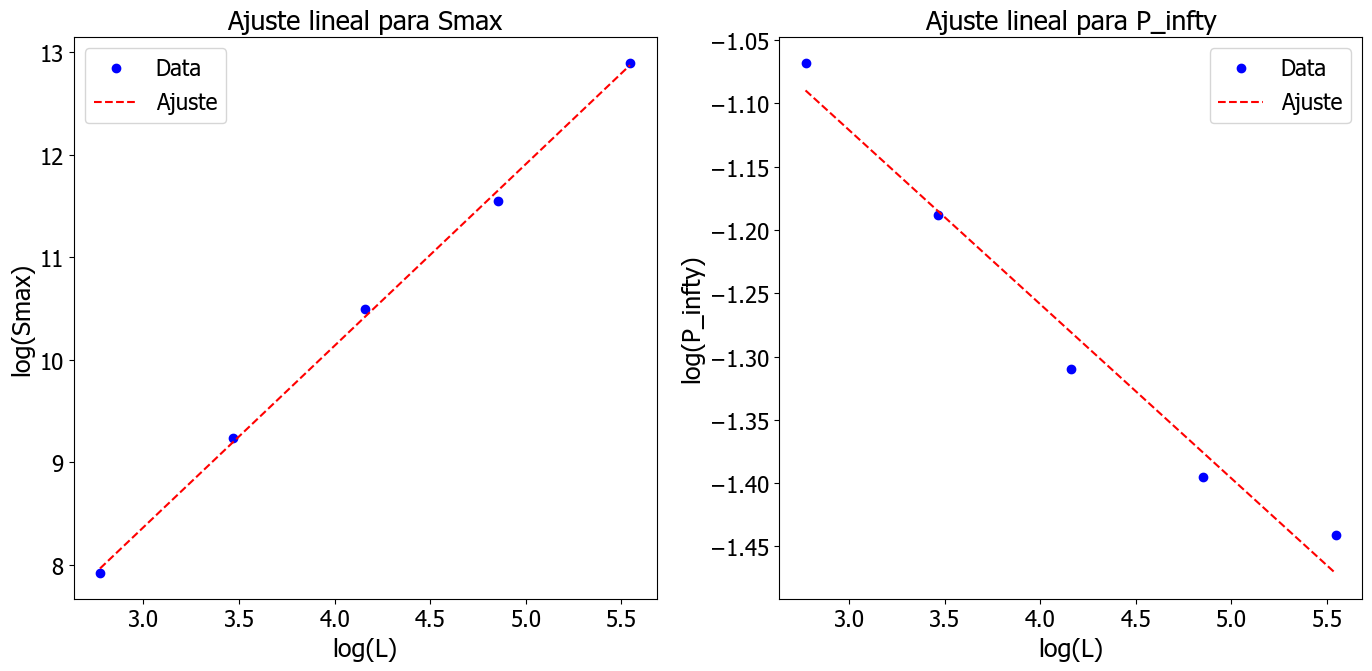

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Gráfica para Smax
slope, corte = lineFit(loglados, logSmax)
ajuste = slope * loglados + corte
axs[0].plot(loglados, logSmax, 'bo', label='Data')
axs[0].plot(loglados, ajuste, 'r--', label='Ajuste')
axs[0].set_xlabel("log(L)", fontsize=18)
axs[0].set_ylabel("log(Smax)", fontsize=18)
axs[0].set_title("Ajuste lineal para Smax")
axs[0].legend()

# Gráfica para P_infty
slope, corte = lineFit(loglados, logP_infty)
ajuste = slope * loglados + corte
axs[1].plot(loglados, logP_infty, 'bo', label='Data')
axs[1].plot(loglados, ajuste, 'r--', label='Ajuste')
axs[1].set_xlabel("log(L)", fontsize=18)
axs[1].set_ylabel("log(P_infty)", fontsize=18)
axs[1].set_title("Ajuste lineal para P_infty")
axs[1].legend()

plt.tight_layout()
plt.show()

In [73]:
print("Slope (gamma/nu) for Smax: ", slope)
print("Intercept (log(A)) for Smax: ", corte)

# Repetir el cálculo para P_infty
slope, corte = lineFit(loglados, logP_infty)
print("Slope (-beta/nu) for P_infty: ", slope)
print("Intercept (log(C)) for P_infty: ", corte)

Slope (gamma/nu) for Smax:  -0.137549560993463
Intercept (log(A)) for Smax:  -0.7083665460193382
Slope (-beta/nu) for P_infty:  -0.137549560993463
Intercept (log(C)) for P_infty:  -0.7083665460193382


### Discusión

El cambio en Smax al aumentar el número de lados (L) es exponencial, con un exponente y prefactor específicos. La gráfica log-log confirma este comportamiento. Este aumento exponencial se explica por la mayor cantidad de lugares disponibles para la formación de clusters. El parámetro de orden en pc también se comporta como una ley de potencias con una pendiente negativa, aunque el ajuste a la recta no es tan preciso como en el caso de Smax. Se requieren análisis más profundos para comprender mejor el comportamiento del parámetro de orden.